# Predicting Speed

With today’s cycling computers and smart sensors, bicyclists are able to capture a rich collection of data from each ride. GPS units provide high-resolution positional data, which translates directly into speed, distance, and elevation profiles. Additional sensors capture the rider’s power output, cadence, heart rate, respiratory rate, and more. Together, these telemetry data enable precise monitoring, comparative analysis, and the optimization of training strategies.

This notebook is all about *speed*. In particular, I explore how well we can predict a rider's speed based on the available telemetry.   

Intuitively, we know the harder that a rider pedals, the faster they go. But there are multiple other factors that could affect their speed. If a rider is climbing a hill, for example, much of their power is needed to overcome gravity. A rider who is standing&mdash;not sitting&mdash;is able to generate greater torque on the pedals, but their overall pedal stroke may be less efficient. To determine the best predictors of speed, I build a linear model and use feature selection to explore many of the available data channels.


-----------
### Core Functions

#### Read File(s)

Most cycling computers record telemetry data in a .FIT file, the “Flexible and Interoperable Data Transfer” format. 

You may need to `pip install fitparse`, which is a Python library for reading .FIT files. Documentation for fitparse is available at https://dtcooper.github.io/python-fitparse/.

In [1]:
from datetime import datetime
from typing import Iterable, Dict, Any
import pandas as pd
from fitparse import FitFile


# unit conversions 
def semicircles_to_degrees(x):
    """Garmin stores lat/long in semicircles; convert to degrees."""
    if x is None:
        return None
    return x * 180.0 / (2**31)

def ms_to_kph(x):
    return None if x is None else x * 3.6

def ms_to_mph(x):
    return None if x is None else x * 2.23693629


def _message_to_row(msg) -> Dict[str, Any]:
    """Turn a fitparse message into a flat dict of field -> value."""
    row = {}
    for f in msg:
        # f.name is a normalized field name, f.value is already decoded to Python types
        row[f.name] = f.value
    # Timestamps from FIT are usually naive UTC; make them pandas-friendly.
    if "timestamp" in row and isinstance(row["timestamp"], datetime):
        row["timestamp"] = pd.to_datetime(row["timestamp"], utc=True)
    return row


def read_fit_to_dataframe(path: str, message: str = "record") -> pd.DataFrame:
    """
    Read a FIT file and return a DataFrame for the given message type.
    Common message types: 'record', 'lap', 'session', 'event', 'device_info', etc.
    """
    fit = FitFile(path)
    rows = [_message_to_row(m) for m in fit.get_messages(message)]
    df = pd.DataFrame(rows)

    # Basic normalization & sorting if timestamp exists
    if not df.empty and "timestamp" in df.columns:
        df = df.sort_values("timestamp").reset_index(drop=True)

    # Optional: convert some common fields if present
    if "position_lat" in df.columns:
        df["lat"] = df["position_lat"].apply(semicircles_to_degrees)
    if "position_long" in df.columns:
        df["lon"] = df["position_long"].apply(semicircles_to_degrees)
    # Example speed conversions (FIT 'speed' is m/s)
    if "speed" in df.columns:
        df["speed_kmh"] = df["speed"].apply(ms_to_kmh)
        df["speed_mph"] = df["speed"].apply(ms_to_mph)

    return df


def read_fit_multiple(path: str, messages: Iterable[str] = ("record", "lap", "session")) -> Dict[str, pd.DataFrame]:
    """Convenience: get several message types at once."""
    return {m: read_fit_to_dataframe(path, m) for m in messages}


In [2]:
from datetime import datetime
from typing import List, Tuple
import pandas as pd
from fitparse import FitFile


def _to_dt_utc(x):
    return pd.to_datetime(x, utc=True) if isinstance(x, datetime) else x


def read_fit_events(path: str) -> pd.DataFrame:
    """
    Extract 'event' messages from a FIT file into a tidy DataFrame.

    Returns columns typically seen in FIT 'event' messages:
        - timestamp (UTC)
        - event (e.g., 'timer', 'lap')
        - event_type (e.g., 'start', 'stop', 'marker')
        - data (contextual value; varies by event)
        - event_group (int grouping)
        - timer_trigger (for timer events, if present)
        - sport (if present on some devices/firmwares)
        - other developer/custom fields are included if present
    """
    fit = FitFile(path)
    rows = []
    for msg in fit.get_messages("event"):
        row = {}
        for f in msg:
            row[f.name] = f.value
        if "timestamp" in row:
            row["timestamp"] = _to_dt_utc(row["timestamp"])
        rows.append(row)

    df = pd.DataFrame(rows).sort_values("timestamp").reset_index(drop=True)
    return df


def timer_segments(events_df: pd.DataFrame) -> List[Tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Build (start, stop) segments where the activity timer is 'running'
    based on 'event' == 'timer' with event_type in {'start', 'stop'}.

    Returns a list of (start_ts, stop_ts) tuples in UTC.
    If the timer ends without an explicit 'stop' (e.g., file ended),
    the stop is None to indicate 'runs to end of file'.
    """
    if events_df.empty:
        return []

    e = events_df.copy()
    e = e[(e.get("event") == "timer") & (e["event_type"].isin(["start", "stop"]))].copy()
    e = e.sort_values("timestamp").reset_index(drop=True)

    segments = []
    current_start = None
    for _, r in e.iterrows():
        if r["event_type"] == "start":
            # if we see repeated starts, close previous open segment
            if current_start is not None:
                segments.append((current_start, r["timestamp"]))
            current_start = r["timestamp"]
        elif r["event_type"] == "stop":
            if current_start is not None:
                segments.append((current_start, r["timestamp"]))
                current_start = None

    # If timer was running at the end, leave open-ended segment
    if current_start is not None:
        segments.append((current_start, None))

    return segments


def label_records_with_timer(df_records: pd.DataFrame, segments: List[Tuple[pd.Timestamp, pd.Timestamp]]) -> pd.DataFrame:
    """
    Add an 'is_timer_running' boolean flag to the per-record DataFrame
    (from message='record') using the provided timer segments.
    Open-ended segments (stop=None) are treated as running through the end.
    """
    if df_records.empty or "timestamp" not in df_records.columns or not segments:
        out = df_records.copy()
        out["is_timer_running"] = False
        return out

    # Build an interval index for fast lookup
    # Expand open-ended stop=None to max timestamp in records
    end_fallback = df_records["timestamp"].max()
    ivals = pd.IntervalIndex.from_tuples(
        [(start, stop if stop is not None else end_fallback) for start, stop in segments],
        closed="both"
    )

    # Vectorized membership: for each timestamp, check if it lies in any interval
    # (For large data, you can accelerate with intervaltree or merge-asof.)
    ts = df_records["timestamp"]
    is_running = pd.Series(False, index=df_records.index)
    for iv in ivals:
        is_running |= ts.between(iv.left, iv.right, inclusive="both")

    out = df_records.copy()
    out["is_timer_running"] = is_running
    return out


#### Trendline Plots

.FIT files contain multiple dimensions: speed, cadence, elevation, and more. One of the best ways to understand those data (and their relation to each other) is to visualize them as trend lines. 

The following function plots each trend line in its own color. And because each trend line will have its own unit of measure (e.g., speed is measured in meters per second (m/s), heart rate in beats per minute (bpm), etc.), the resulting plot also supports multiple $y$-axis scales. 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from typing import Sequence, Mapping, Optional, List, Union

def _color_list(n: int, colormap: Union[str, None] = "tab10") -> List:
    """Get n visually distinct colors from a colormap."""
    if isinstance(colormap, str) and colormap:
        cmap = get_cmap(colormap)
        return [cmap(i / max(1, n - 1)) for i in range(n)]
    base = plt.rcParams["axes.prop_cycle"].by_key().get("color", 
        ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"])
    return [base[i % len(base)] for i in range(n)]

def plot_trends_multi_axis(
    df: pd.DataFrame,
    columns: Sequence[str],
    axis_for: Optional[Mapping[str, int]] = None,
    labels: Optional[Mapping[str, str]] = None,
    title: Optional[str] = None,
    right_offset: float = 0.12,
    colormap: Optional[str] = "tab10",
    colors: Optional[Sequence[str]] = None,
    x_col: str = "timestamp",   # NEW: choose "timestamp" or "minutes"
    x_label: Optional[str] = None,
):
    """
    Plot multiple time-series with separate y-axes and a flexible x-axis.
    
    Parameters
    ----------
    df : DataFrame
        Must contain x_col and the requested columns.
    columns : list[str]
        Data columns to plot.
    x_col : str
        Column name to use for the x-axis ("timestamp" or e.g. "minutes").
    x_label : str, optional
        Custom x-axis label (defaults to x_col).
    """
    if x_col not in df.columns:
        raise ValueError(f"DataFrame must contain '{x_col}' column.")
    for c in columns:
        if c not in df.columns:
            raise ValueError(f"Column '{c}' not found in DataFrame.")

    work = df.copy().sort_values(x_col).reset_index(drop=True)

    # Default axis mapping
    if axis_for is None:
        axis_for = {c: i for i, c in enumerate(columns)}

    # Build axes
    fig, ax0 = plt.subplots(figsize=(14, 5))
    axes: List[plt.Axes] = [ax0]
    for i in range(1, max(axis_for.values(), default=0) + 1):
        ax_i = ax0.twinx()
        if i >= 2:
            ax_i.spines["right"].set_position(("axes", 1 + right_offset * (i - 1)))
        axes.append(ax_i)

    # Decide colors
    if colors is not None and len(colors) >= len(columns):
        series_colors = list(colors)[:len(columns)]
    else:
        series_colors = _color_list(len(columns), colormap=colormap)

    # Plot lines
    handles, labels_out = [], []
    for i, c in enumerate(columns):
        ax_idx = axis_for.get(c, 0)
        y = pd.to_numeric(work[c], errors="coerce")
        lbl = (labels.get(c, c) if labels else c)
        line, = axes[ax_idx].plot(work[x_col], y,
                                  linewidth=1.6, alpha=0.95,
                                  color=series_colors[i], label=lbl)
        handles.append(line)
        labels_out.append(lbl)

    # Cosmetics
    ax0.set_xlabel(x_label if x_label else x_col.capitalize())
    ax0.grid(True, linestyle="--", alpha=0.45)
    if title:
        ax0.set_title(title)

    # Add one ylabel per axis
    for idx, ax in enumerate(axes):
        cols_on_axis = [c for c in columns if axis_for.get(c, 0) == idx]
        if cols_on_axis:
            first = cols_on_axis[0]
            ax.set_ylabel(labels.get(first, first) if labels else first)

    ax0.legend(handles, labels_out, loc="upper center",
               ncol=min(len(labels_out), 5), frameon=False)

    fig.tight_layout()
    plt.show()


#### Convert events to trends

.FIT files contain two key types of data: **records** and **events**. (There are other data types, but records and events are the most relevent.): 

- Records are snapshots of the continously streamed data: Every second, measures of the rider's latitude, longitude, elevation, speed, cadence, and more are recorded. 

- Events are asyncronous activities, like the change of gears that can happen at any time during a ride. 

Converting those events into records makes it easier to use them as features in the model.   

In [4]:
import pandas as pd
from typing import Optional, Callable, List, Dict, Any

def apply_event_trend(
    df: pd.DataFrame,
    events_df: pd.DataFrame,
    *,
    event_name: str,                 # e.g., "rear_gear_change"
    value_col: str,                  # e.g., "rear_gear" in events_df
    target_col: Optional[str] = None,# e.g., "rear_gear" in df (defaults to value_col)
    event_col: str = "event",        # column in events_df that holds the event name
    initial: Optional[Any] = None,   # value to use before the first event (else NaN)
    transform: Optional[Callable[[pd.Series], pd.Series]] = None, # optional transform
    mark_changes: bool = False,      # add a boolean column marking change instants
) -> pd.DataFrame:
    """
    Merge 'event' changes into a continuous 'trend' column in df, synced by timestamp.
    - At each df timestamp, assigns the most recent event value at or before that time.
    - Gaps between events are naturally forward-filled by merge_asof.
    """
    if "timestamp" not in df.columns or "timestamp" not in events_df.columns:
        raise ValueError("Both df and events_df must contain a 'timestamp' column.")
    if event_col not in events_df.columns:
        raise ValueError(f"events_df must contain '{event_col}' column.")
    if value_col not in events_df.columns:
        raise ValueError(f"events_df must contain '{value_col}' column.")

    target_col = target_col or value_col

    # Prepare left (df) and right (filtered events) tables
    left = df.copy()
    left["timestamp"] = pd.to_datetime(left["timestamp"], utc=True, errors="coerce")
    left = left.sort_values("timestamp")

    ev = events_df.copy()
    ev["timestamp"] = pd.to_datetime(ev["timestamp"], utc=True, errors="coerce")
    ev = ev[(ev[event_col] == event_name)].sort_values("timestamp")

    # Keep only timestamp + value; drop NaNs; if dup timestamps, keep the last
    ev = ev[["timestamp", value_col]].dropna(subset=[value_col])
    ev = ev.drop_duplicates(subset=["timestamp"], keep="last")

    # As-of merge: take the latest event at or before each df timestamp
    merged = pd.merge_asof(
        left,
        ev.rename(columns={value_col: f"__{target_col}_evt"}),
        on="timestamp",
        direction="backward",
    )

    # Optionally transform values (e.g., map codes to labels)
    series = merged[f"__{target_col}_evt"]
    if transform is not None:
        series = transform(series)

    # Seed pre-first-event values with 'initial' (or leave NaN)
    if initial is not None:
        series = series.fillna(initial)

    merged[target_col] = series
    merged = merged.drop(columns=[c for c in merged.columns if c.startswith(f"__{target_col}_evt")])

    # Optional: flag rows exactly at change instants
    if mark_changes and not ev.empty:
        change_col = f"{target_col}_changed"
        merged[change_col] = merged["timestamp"].isin(ev["timestamp"]).astype(bool)

    return merged


def events_to_trends(
    df: pd.DataFrame,
    events_df: pd.DataFrame,
    mappings: List[Dict[str, Any]],
    *,
    event_col: str = "event"
) -> pd.DataFrame:
    """
    Apply multiple event→trend mappings.
    Each mapping dict can include:
      - event_name (str)     e.g., "rear_gear_change"
      - value_col (str)      e.g., "rear_gear"
      - target_col (str)     optional; defaults to value_col
      - initial (Any)        optional seed before first event
      - transform (callable) optional value transform
      - mark_changes (bool)  optional, adds '<target>_changed'
    """
    out = df.copy()
    for m in mappings:
        out = apply_event_trend(
            out, events_df,
            event_name=m["event_name"],
            value_col=m["value_col"],
            target_col=m.get("target_col"),
            event_col=event_col,
            initial=m.get("initial"),
            transform=m.get("transform"),
            mark_changes=m.get("mark_changes", False),
        )
    return out


---
### Data 

I'm using a .FIT file generated from one of my own rides. I'm including it with this notebook, for privacy reasons, however, I have stripped location data from the file. 

The ride itself was a pretty typical for me: It was created before this project was envisioned, so the data should be representative of real-world results. 

Over the course of a nearly one-hour ride, I used a Garmin Edge 1050 to capture data. The supplemental devices included a Garmin HRM Pro Plus, Garmin Vector 3 pedals, and SRAM eTap shifters and derailleurs. Data was captured at 1-second intervals, resulting in 3,200 records. Each record contain 28 (mostly numeric) columns. Key features include `enhanced_speed`, `power`, `cadence`, and more. These will be explored more fully in the code blocks below. 

The Edge also captured 299 asyncronous events (e.g., gear changes). Each events data frame contains 12 columns. Key event values include "rear_gear_change" and "rider_position_change" (found in the `event` column). Again, these will be explored more fully explored below. 

A `timestamp` is available in both data frames, allowing records and events to be synchronized.  

In [5]:
df = read_fit_to_dataframe('FIT_files/2025-09-11_geo_stripped.fit')
events_df = read_fit_events('FIT_files/2025-09-11_geo_stripped.fit')


In [6]:
print("Shape of the records data:", df.shape)
print("Shape of the events data:", events_df.shape) 

Shape of the records data: (3200, 28)
Shape of the events data: (299, 12)


---
### Data Cleaning

The data needed to be cleaned for a variety of reasons. (See the comments in the code blocks below.)

In [7]:
# drop columns that don't contain *any* data. 
df = df.dropna(axis=1, how="all")

# see what remains
df.columns

Index(['distance', 'enhanced_altitude', 'enhanced_speed', 'heart_rate',
       'power', 'temperature', 'timestamp', 'unknown_107', 'unknown_134',
       'unknown_137', 'unknown_138', 'unknown_144', 'unknown_108',
       'accumulated_power', 'cadence', 'fractional_cadence',
       'left_pedal_smoothness', 'left_torque_effectiveness',
       'right_pedal_smoothness', 'right_torque_effectiveness', 'left_pco',
       'right_pco', 'right_power_phase', 'right_power_phase_peak',
       'left_right_balance', 'left_power_phase', 'left_power_phase_peak',
       'unknown_90'],
      dtype='object')

In [8]:
# rename "unknown" columns (when their purpose is known)
df = df.rename(columns={
    "unknown_137": "stamina",
    "unknown_138": "stamina_potential",
    "unknown_144": "external_hr",
    "unknown_108": "breathing_rate",
    "unknown_90": "perf_condition"
})

In [9]:
# convert speed to familiar units
df['speed_mph'] = ms_to_mph(df['enhanced_speed'])
df['speed_kph'] = ms_to_kph(df['enhanced_speed'])


In [10]:
# convert time (of day) to a duration (minutes since the start of the ride)
# this is largely for convenience: It's easier to find/specify an event ~20 minutes into a ride than the exact chronological time. 

# determine the starting time
t0 = df["timestamp"].min()

# compute minutes from start
df["minutes"] = (df["timestamp"] - t0).dt.total_seconds() / 60.0

In [11]:
# change in altitude (i.e., incline) is potentially useful, 
# telling us whether the rider is climbing, decending, or on a flat 
df["altitude_change"] = df["enhanced_altitude"].diff()

# there is no change in altitude at the start of the ride
df.loc[0, "altitude_change"] = 0

In [12]:
# convert rider position ("standing" or "seated") into a trend line
df = apply_event_trend(
    df, 
    events_df, 
    event_name = 'rider_position_change', 
    value_col = 'rider_position',
)

# convert "standing" or "seated" into a single categorical variable: seated or not
df["seated"] = df["rider_position"] == 'seated'
df["seated"] = df["seated"].astype(int)
df = df.drop(columns = ['rider_position'])

In [13]:
# left-right balance contains non-numeric entries
df.loc[df['left_right_balance'] == 'right', 'left_right_balance']

59      right
78      right
79      right
80      right
133     right
        ...  
3059    right
3060    right
3145    right
3146    right
3147    right
Name: left_right_balance, Length: 80, dtype: object

In [14]:
# keep only numeric entries
df = df[df['left_right_balance'] != 'right']

# convert data type to numeric
df["left_right_balance"] = pd.to_numeric(df["left_right_balance"], errors="coerce").astype("float64")


In [15]:
# we have some missing data: this is because I wan't pedaling.
# all of these values should be 0 

cols = [
    'power',
    'cadence',
    'left_right_balance', 
    'left_pedal_smoothness', 
    'left_torque_effectiveness', 
    'right_pedal_smoothness',
    'right_torque_effectiveness', 
    'left_pco', 
    'right_pco', 
]

#df.loc[:, cols] = df[cols].apply(lambda x: x.fillna(x.mean()))
df.loc[:, cols] = df[cols].fillna(0)

In [16]:
# fix gear values to match the actual gears on the bike

events_df.loc[events_df['rear_gear'] == 23, 'rear_gear'] = 28
events_df.loc[events_df['rear_gear'] == 22, 'rear_gear'] = 25
events_df.loc[events_df['rear_gear'] == 21, 'rear_gear'] = 22
events_df.loc[events_df['rear_gear'] == 18, 'rear_gear'] = 19

#### Calculate the Gear Ratio

The gear ratio represents the combined gearing of the chainring (front gear) and cog (rear gear):

$G = \frac{T_f}{T_r}$

Where:

- Front chainring teeth = $T_f$  
- Rear cog teeth = $T_r$  

In [17]:
# gear ratio
events_df['gear_ratio'] = events_df['front_gear'] / events_df['rear_gear']

In [18]:
# convert the gear ratio into a trend line
df = apply_event_trend(
    df, 
    events_df, 
    event_name = 'rear_gear_change', 
    value_col = 'gear_ratio',
)

#### Gear-based Formula for Calculating Speed

The relationship between the **gear ratio, cadence, wheel size, and speed** is mechanical.  

$$
\text{speed (km/h)} = \frac{RPM_c \times G \times C \times 60 \frac{\text{minutes}}{\text{hour}}}{1000 \frac{\text{meters}}{\text{kilometer}}}
$$

Where:

- **Gear ratio** =  $G = \frac{T_f}{T_r}$
- **Cadence** (crank revolutions per minute) = $RPM_c$
- **Wheel circumference** =  $C$ 

This will give us a baseline to compare ML-based model(s) to.


In [19]:
# this value is based on the size of the rear wheel on my bike (700x25)
# source: https://support.wahoofitness.com/hc/en-us/articles/115000738484-Tire-Size-Wheel-Circumference-Chart
circumference = 2.109 # in meters

# cadence is in RPM, so multiply by (1 minute / 60 seconds) to convert speed to meters/second
df['speed_est'] = df['cadence'] * (df['gear_ratio']  / 60) * circumference

#### Visualize the Speed Estimate

The forumla-based model does a pretty good job estimating speed. 

However, the formula predicts $speed = 0$ when the $cadence = 0$, which is a fundamental flaw of the formula-based model. 

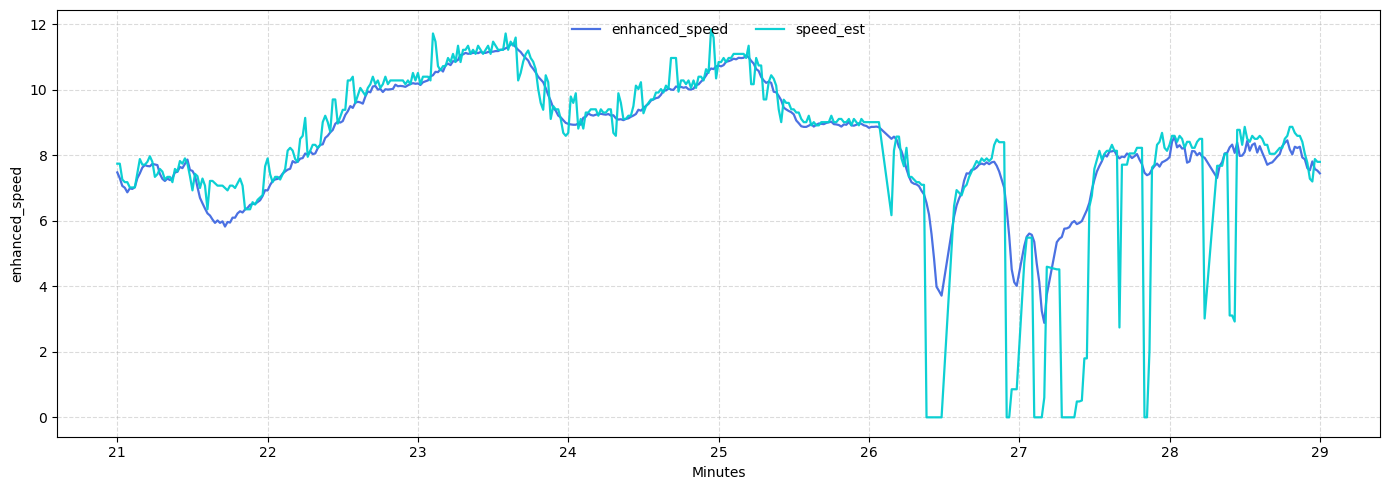

In [57]:
plot_trends_multi_axis(
    df[df["minutes"].between(21, 29, inclusive="both")], 
    ['enhanced_speed', 'speed_est' ], 
    colors = ['royalblue', 'darkturquoise'],
    x_col = 'minutes', 
    axis_for = {'enhanced_speed': 0, 'speed_est': 0}
)

---
### EDA

We don't need to consider features that aren't directly related to speed: e.g., location (i.e., latitude and longitude), the rider's stamina, and more. Based on experience (i.e., domain knowledge), I've reduced the candidate features to the list below.  

In [22]:
candidate_features = [
    'power', 
    'cadence',
    'gear_ratio', 
    'altitude_change',
    'temperature', 
    'seated',
    'left_right_balance', 
    'left_pedal_smoothness', 
    'right_pedal_smoothness',
    'left_torque_effectiveness', 
    'right_torque_effectiveness', 
    # pco = platform center offset
    'left_pco', 
    'right_pco', 
]

df_cleansed = df[['enhanced_speed', 'speed_est'] + candidate_features].copy()
#df_cleansed = df_cleansed[['enhanced_speed', 'speed_est'] + candidate_features].copy()

We start with some simple visualizations. 

This one shows that, perhaps counterintuitively, power doesn't map directly to speed. The trend line for power (red) remains mostly flat, while the trend line for speed (blue) shows noticable dips and spikes between 20 and 30 minutes.

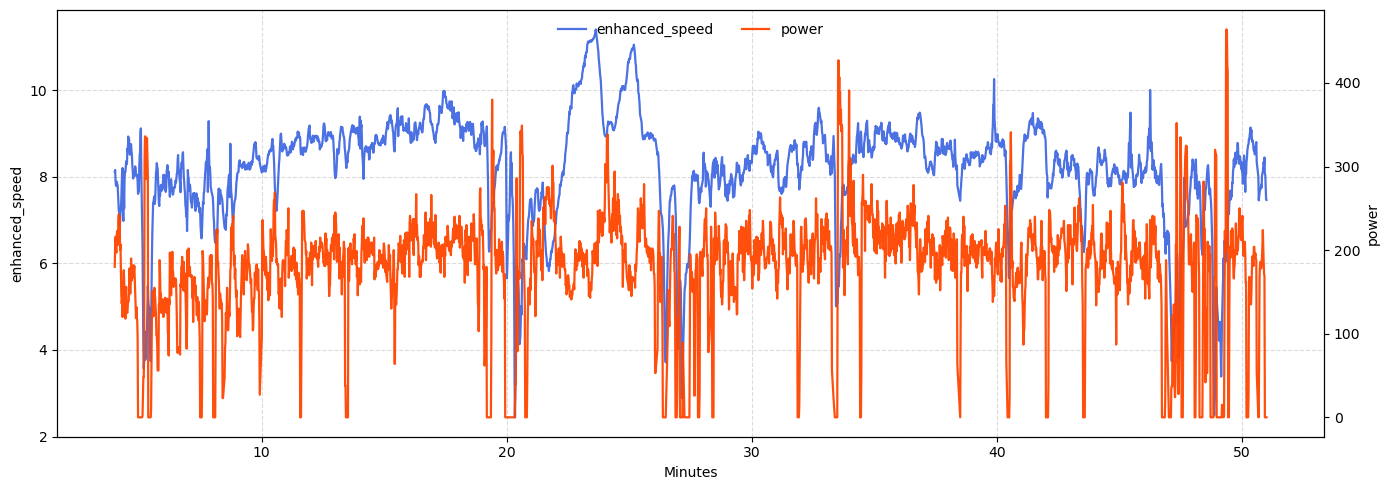

In [23]:
# power doesn't map directly to speed. 

plot_trends_multi_axis(
    df[df["minutes"].between(4, 51)],
    ['enhanced_speed', 'power'], 
    colors = ['royalblue', 'orangered'],
    x_col = 'minutes'
)

Drilling more closely to that time range, we can better see the difference in the trend lines. 

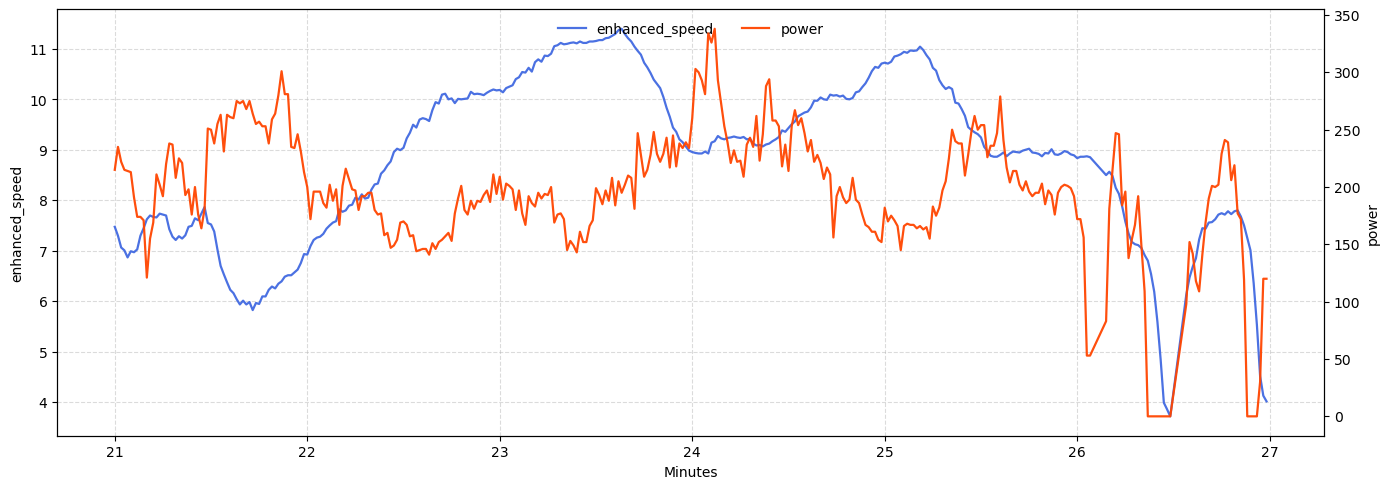

In [24]:
# drill in to better understand the relationship between the two

plot_trends_multi_axis(
    df[df["minutes"].between(21, 27)],
    ['enhanced_speed', 'power'], 
    colors = ['royalblue', 'orangered'],
    x_col = 'minutes'
)

Adding elevation the plot explains some of what's going on. When climbing hills, a proportion of my power output is required to overcome gravity. If my power remains constant, I'll lose speed. Conversely, when descending, gravity will help to increase speed. 

One possible conclusion is that the combination of power and the change in altitude (`altitude_change`) will be useful features.  

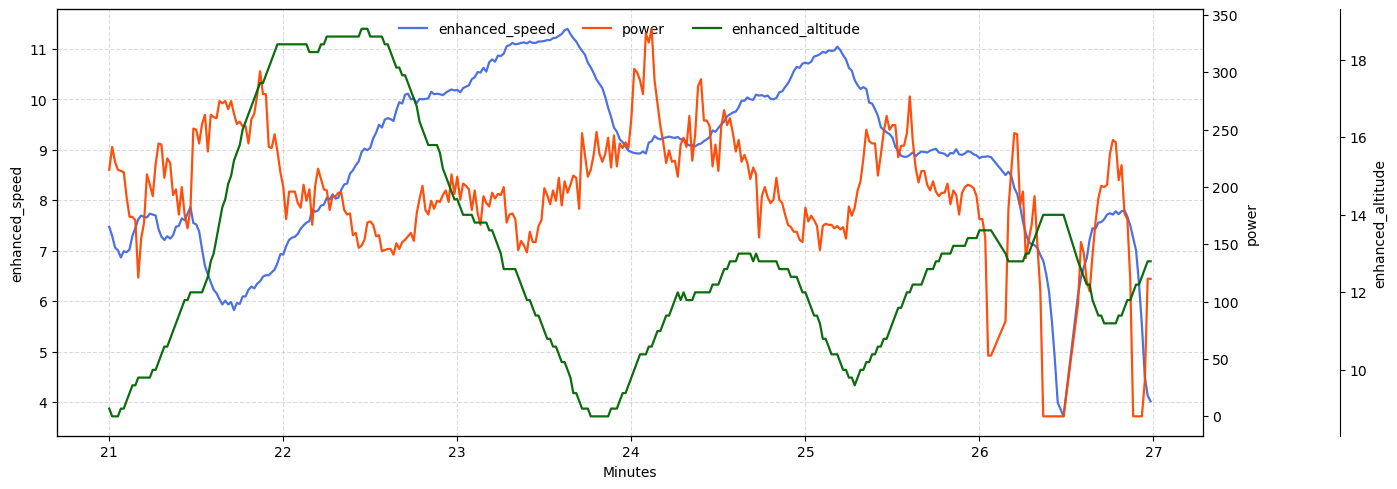

In [25]:
# elevation explains what's going on
# you have to pedal harder when going uphill to overcome gravity
# perhaps power and change in altitude will combine to have good predictive power

plot_trends_multi_axis(
    df[df["minutes"].between(21, 27)],
    ['enhanced_speed', 'power', 'enhanced_altitude'], 
    colors = ['royalblue', 'orangered', 'darkgreen'],
    x_col = 'minutes'
)

Other features show a more direct correlation. 

In this plot, we can see that the gear ratio and speed are highly correlated. This makes sense, of course, based on the gear-based formula in the prior code block.

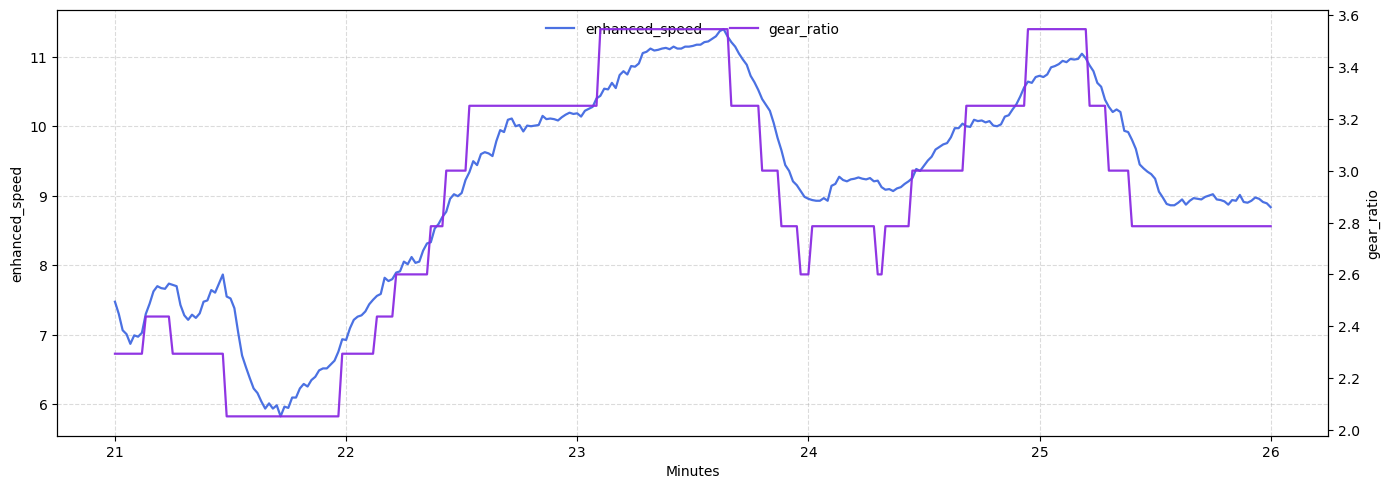

In [26]:
# although there are other features that are directly correlated

plot_trends_multi_axis(
    df[df["minutes"].between(21, 26)], 
    ['enhanced_speed', 'gear_ratio'], 
    colors = ['royalblue', 'blueviolet'],
    x_col = 'minutes'
)

#### Correlation

We want to use correlation to identify features that are good candidates by looking for high correlation with `enhanced_speed`, our target variable. 

We likewise want to identify features that might violate the assumptions of linear regression by being correlated with each other. 

In [27]:
df_cleansed.corr()

,enhanced_speed,speed_est,power,cadence,gear_ratio,altitude_change,temperature,seated,left_right_balance,left_pedal_smoothness,right_pedal_smoothness,left_torque_effectiveness,right_torque_effectiveness,left_pco,right_pco
enhanced_speed,1.000000,0.768321,0.294695,0.630192,0.804619,-0.199898,-0.048847,0.670336,0.500686,0.448926,0.447060,0.418821,0.437755,0.616274,0.497330
speed_est,0.768321,1.000000,0.600449,0.955538,0.576638,0.013464,-0.087053,0.511762,0.846811,0.749667,0.758109,0.772223,0.777679,0.698530,0.607654
power,0.294695,0.600449,1.000000,0.673698,0.077273,0.273456,0.009018,0.038407,0.633406,0.707056,0.699027,0.786705,0.754858,0.277897,0.344169
cadence,0.630192,0.955538,0.673698,1.000000,0.331335,0.098813,-0.096250,0.470261,0.890408,0.797223,0.798770,0.832610,0.825494,0.683319,0.615136
gear_ratio,0.804619,0.576638,0.077273,0.331335,1.000000,-0.203929,-0.028167,0.475170,0.286921,0.231028,0.242421,0.203086,0.233601,0.361332,0.256321
altitude_change,-0.199898,0.013464,0.273456,0.098813,-0.203929,1.000000,-0.011022,-0.117774,0.140785,0.182541,0.198010,0.219693,0.219903,-0.045592,0.037437
temperature,-0.048847,-0.087053,0.009018,-0.096250,-0.028167,-0.011022,1.000000,-0.066298,-0.091103,-0.065625,-0.083772,-0.052061,-0.056914,-0.040343,0.029238
seated,0.670336,0.511762,0.038407,0.470261,0.475170,-0.117774,-0.066298,1.000000,0.335393,0.285870,0.295243,0.212436,0.245722,0.573119,0.423511
left_right_balance,0.500686,0.846811,0.633406,0.890408,0.286921,0.140785,-0.091103,0.335393,1.000000,0.761775,0.798528,0.820568,0.838157,0.540793,0.486845
left_pedal_smoothness,0.448926,0.749667,0.707056,0.797223,0.231028,0.182541,-0.065625,0.285870,0.761775,1.000000,0.786126,0.934327,0.816675,0.448510,0.481047


A heatmap makes it easier to visualize the strength of correlations. 

Below, we can readily see that `enhanced_speed` is most highly correlated with `gear_ratio` $(0.80)$, `seated` $(0.67)$, `cadence` $(0.63)$, and `left_pco` $(0.62)$. (We can ignore `speed_est` because that's not a feature: That's the predicted value from our formula-based model.)

We can see, too, that `left_torque_effectiveness` and `right_torque_effectiveness` are highly correlated with each other, so including both in our model is a potential source of instability. The same is true of `left_torque_smoothness` and `right_torque_smoothness`. However, none of these values is very highly correlated with `enhanced_speed`, so it's unlikely that either will get selected. 

<Axes: >

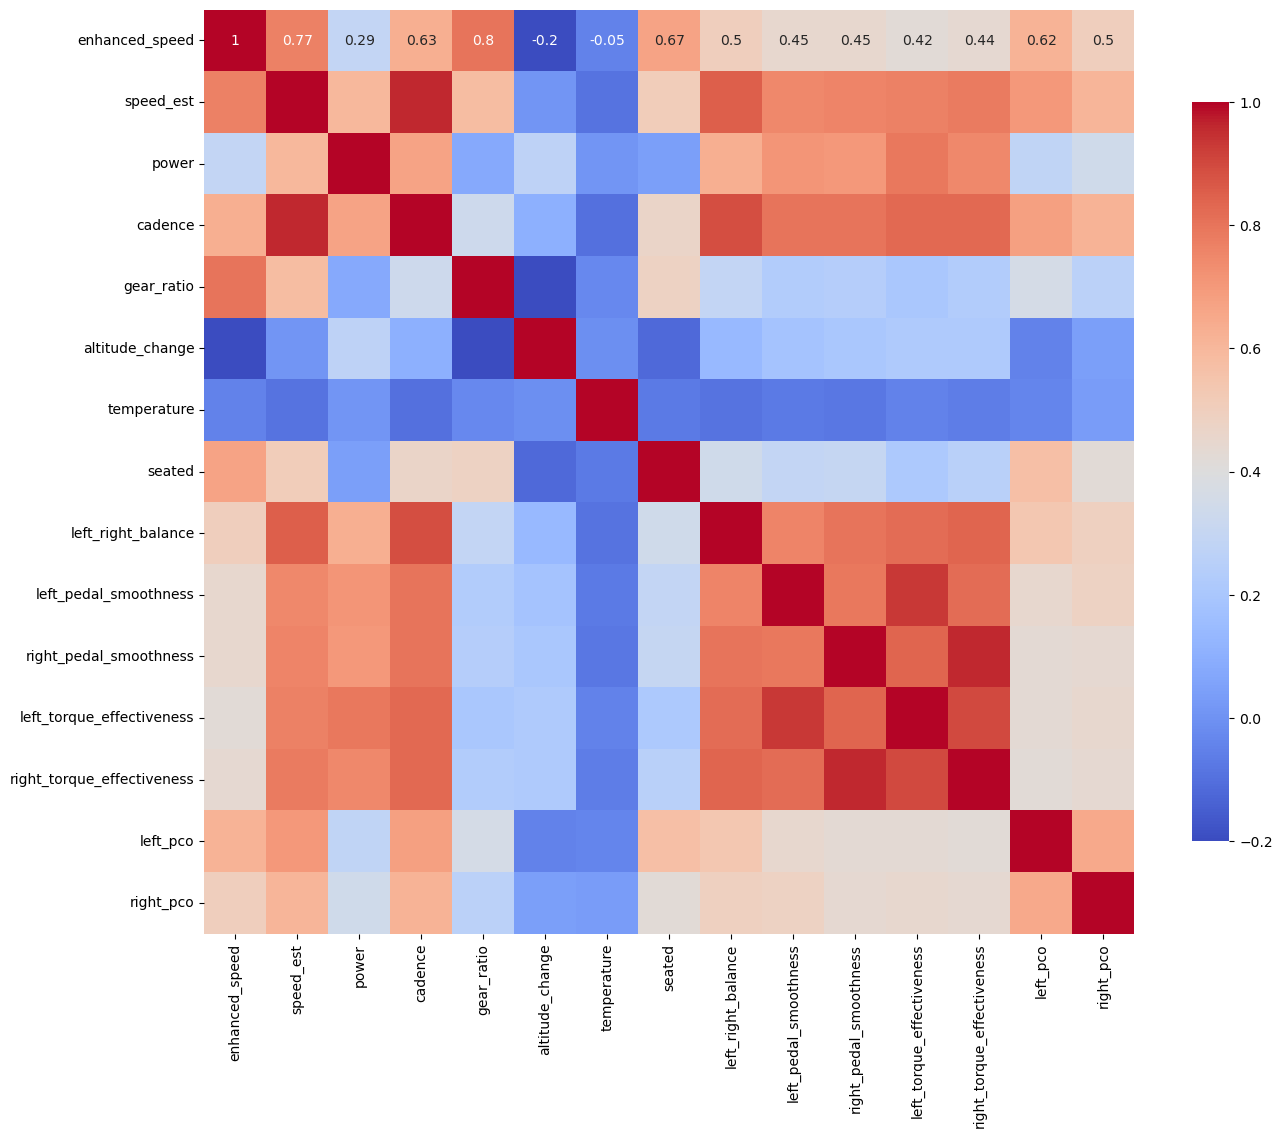

In [28]:
from seaborn import heatmap
plt.figure(figsize=(15, 12))

heatmap(round(df_cleansed.corr(), 2), 
        annot = True, 
        cmap = 'coolwarm', 
        #cmap = sns.cubehelix_palette(as_cmap=True),
        cbar_kws={"shrink": .8}
)

#### Variance Inflation Factor (VIF)

We also want to ensure that our potential features don't exhibit multicolinearity. The threshold of concern for VIF ($≤ 5$). The `_smoothness` and `_effective` features are well above that threshold. Given the fact that none of the features is highly correlated with `enhanced_speed`, the safest thing to do is simply remove them from the list of candidate features.

Both `cadence` and `left_right_balance` have have VIFs, too. Looking back at the correlation plot, it's likely that they're a source of multicolinearity, too. Below, I remove `left_right_balance` as a candidate because its correlation with `enhanced_speed` is lower. 

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import statsmodels.api as sm

# Suppose X is your feature matrix (without target column)
X = df_cleansed.drop(columns = ['enhanced_speed', 'speed_est']).copy() 
X = X.dropna()  # remove NaNs

# Add intercept for VIF calculation
X_with_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                   for i in range(X_with_const.shape[1])]

print(vif_data)


                       feature          VIF
0                        const  3194.002036
1                        power     3.179935
2                      cadence    10.878825
3                   gear_ratio     1.396219
4              altitude_change     1.175745
5                  temperature     1.049725
6                       seated     2.051095
7           left_right_balance     6.167924
8        left_pedal_smoothness     9.541233
9       right_pedal_smoothness    16.917432
10   left_torque_effectiveness    18.735908
11  right_torque_effectiveness    27.735844
12                    left_pco     2.773472
13                   right_pco     2.006592


In [30]:
df_cleansed = df_cleansed.drop(columns = [
    'left_pedal_smoothness', 
    'right_pedal_smoothness',
    'left_torque_effectiveness', 
    'right_torque_effectiveness', 
    'left_right_balance'
]) 

Rerunning the VIF check confirms that we've addressed the outstanding multicolinearity issues. 

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import statsmodels.api as sm

# Suppose X is your feature matrix (without target column)
X = df_cleansed.drop(columns = ['enhanced_speed', 'speed_est']).copy() 
X = X.dropna()  # remove NaNs

# Add intercept for VIF calculation
X_with_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                   for i in range(X_with_const.shape[1])]

print(vif_data)


           feature          VIF
0            const  3161.470703
1            power     2.483152
2          cadence     4.322007
3       gear_ratio     1.373763
4  altitude_change     1.149089
5      temperature     1.038177
6           seated     1.901642
7         left_pco     2.659689
8        right_pco     1.941106


#### Pair Plots  

Explore the relationships between features, developing a better intuition between their correlations and watching out for any non-linearities. 

The pair plot between `enhanced_speed` and `gear_ratio` again illustrates the strength of the correlation between the target variable and the feature/predictor. 

The plots will also help us to identify where there's isn't much variability in the data (e.g., `tempurature`). Unless a feature is categorical in nature, a significant lack of variability suggests that the feature won't be useful as a predictor. 

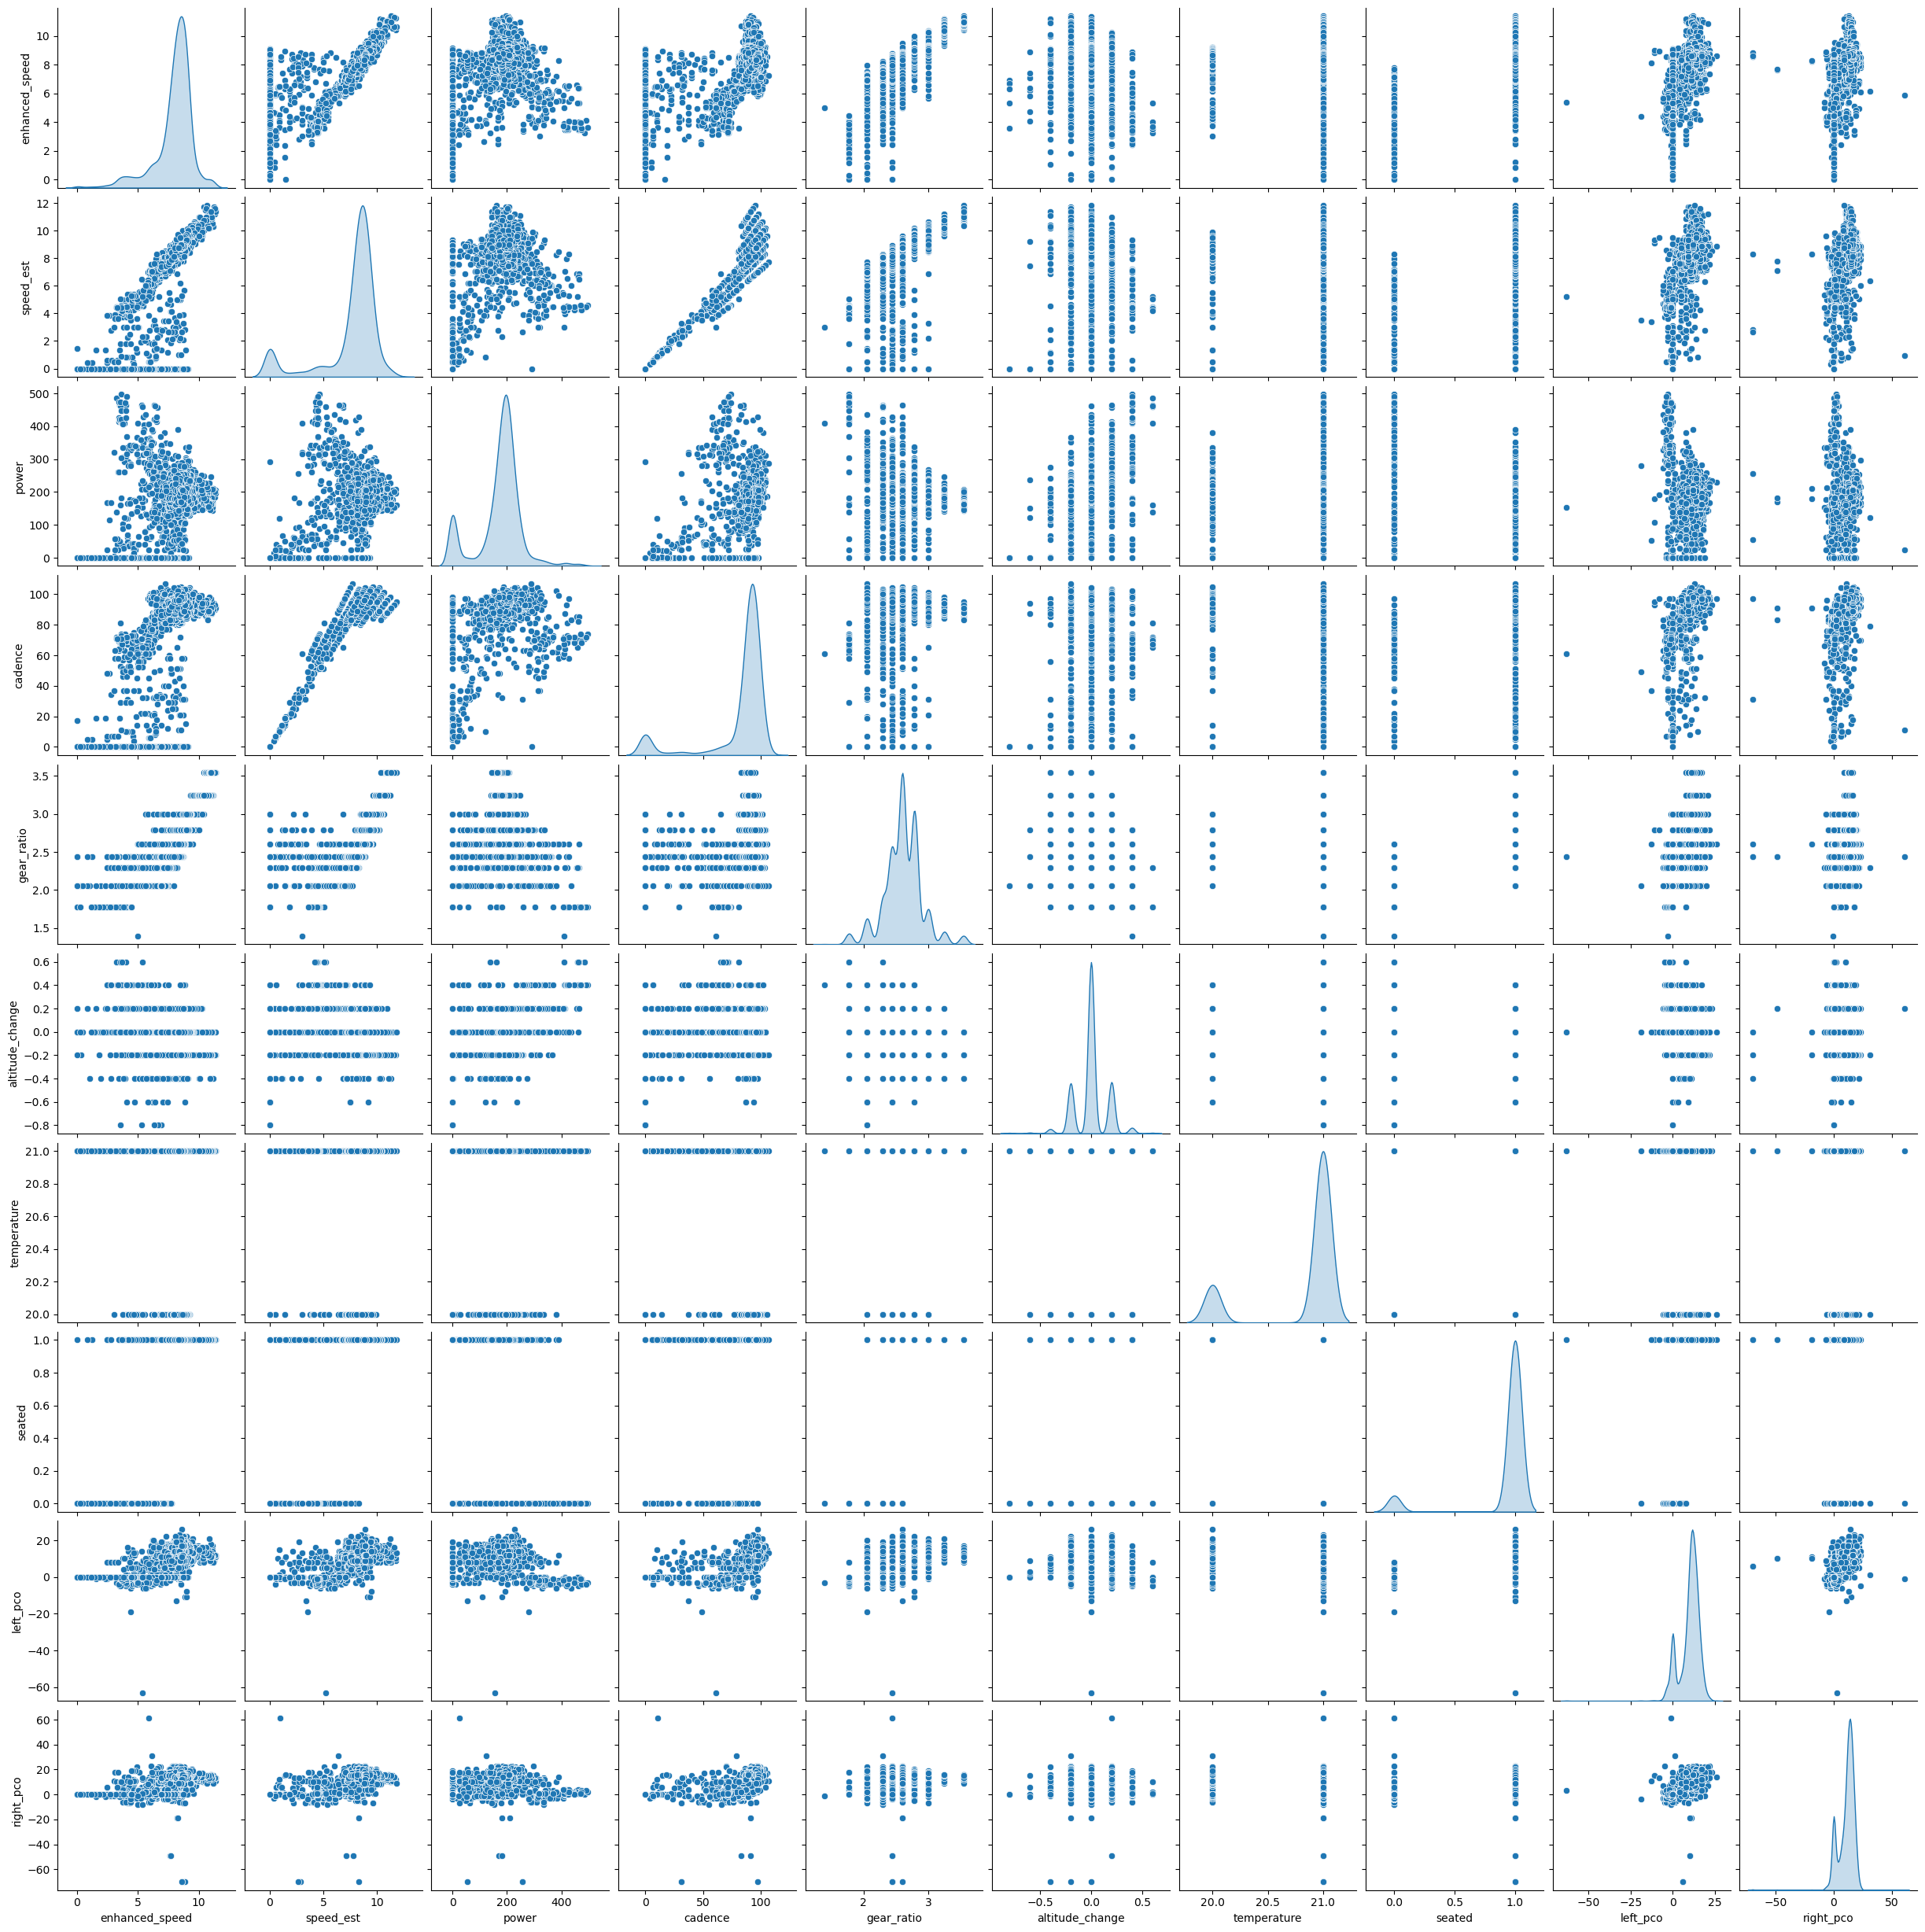

In [32]:
import warnings
import seaborn as sns

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    sns.pairplot(df_cleansed.select_dtypes(include='number'), diag_kind='kde')

#### Scatter plot 

The pair plot between `enhanced_speed` and `speed_est` is especially useful, because illustrate how a scatter plot gives us a way to visually compare predictions vs actuals. 

Below is a function that we can use for our model's predictions. 

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_predicted_vs_actual(
    y_true,
    y_pred,
    *,
    y_true_label: str = "Actual",
    y_pred_label: str = "Predicted",
    units: str = "",
    title: str = "Predicted vs. Actual",
    ax: plt.Axes = None,
    scatter_kwargs: dict = None,
):
    """
    Plot predicted (or estimated) values vs actual values with a 1:1 reference line.

    Parameters
    ----------
    y_true : array-like
        Actual values.
    y_pred : array-like
        Predicted/estimated values.
    y_true_label : str, default="Actual"
        Label for actual values axis.
    y_pred_label : str, default="Predicted"
        Label for predicted/estimated values axis.
    units : str, default=""
        Units string appended to axis labels (e.g., "mph").
    title : str, default="Predicted vs. Actual"
        Title for the plot.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, creates a new figure.
    scatter_kwargs : dict, optional
        Extra keyword arguments passed to plt.scatter (e.g., color, alpha, s).
    """
    y_true = pd.Series(y_true).dropna()
    y_pred = pd.Series(y_pred).dropna()

    if scatter_kwargs is None:
        scatter_kwargs = dict(alpha=0.6, edgecolor="k")

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(y_true, y_pred, **scatter_kwargs)

    # 1:1 line
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, "r--", linewidth=1)

    ax.set_xlabel(f"{y_true_label} {units}".strip())
    ax.set_ylabel(f"{y_pred_label} {units}".strip())
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.5)

    return ax


<Axes: title={'center': 'Predicted vs. Actual'}, xlabel='enhanced_speed', ylabel='speed_est'>

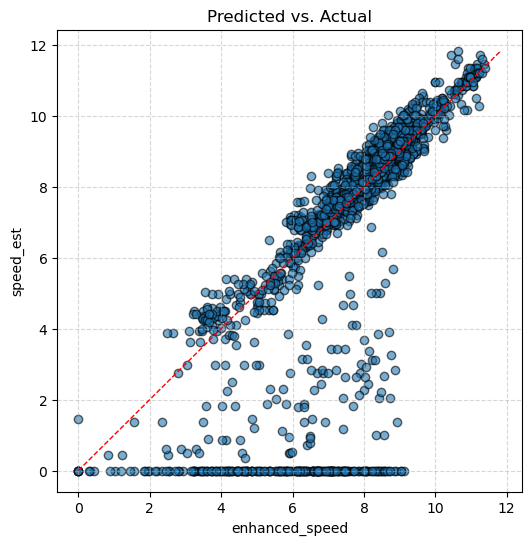

In [34]:
# validate that we've replicated the pair plot
plot_predicted_vs_actual(
    df_cleansed["enhanced_speed"], 
    df_cleansed["speed_est"],
    y_true_label = "enhanced_speed",
    y_pred_label= "speed_est",
)


---
### Model Training

#### Train/Test Split

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Features (all but target) and target
X = df_cleansed.drop(columns=["enhanced_speed"])
y = df_cleansed["enhanced_speed"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Baseline Model Performance

As mentioned above, we'll use the fixed relationship between gear ratio, cadence, wheel size, and speed as our baseline model. 

Here, we'll calculate performance metrics (i.e., $R^2$ and $RMSE$) and visualize the fit. 

In [36]:
# Baseline
r2 = r2_score(y_test, X_test['speed_est'])
rmse = np.sqrt(mean_squared_error(y_test, X_test['speed_est']))

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f} m/s")

R²: -0.496
RMSE: 1.907 m/s


The forumla-based model, our ostensible baseline, performs *very* poorly: Its $R^2$ is actually *below* zero. 

In the plot below, which is based on just validation data, we can easily see that the formula-based model fails when `cadence` = $0$. 

<Axes: title={'center': 'Predicted vs. Actual'}, xlabel='Actual', ylabel='Formula-based Estimate'>

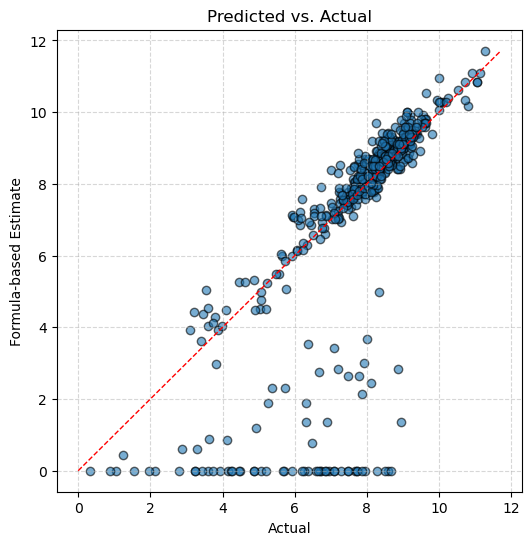

In [37]:
# predicted vs actual for just the test data
plot_predicted_vs_actual(y_test, X_test['speed_est'], y_pred_label = 'Formula-based Estimate')

Removing records where `cadence` = $0$, we can gauge how well the model works for the scenarios where the formula is valid. 

In [38]:
mask = X_test["cadence"] != 0

r2 = r2_score(y_test[mask], X_test.loc[mask, 'speed_est'])
rmse = np.sqrt(mean_squared_error(y_test[mask], X_test.loc[mask, 'speed_est']))

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f} m/s")

R²: 0.393
RMSE: 1.009 m/s


After removing recods where `cadence` = $0$, the formula-based model does better. However, we can still see that it underestimates the actual speed in a number of cases. 

<Axes: title={'center': 'Predicted vs. Actual'}, xlabel='Actual', ylabel='Formula-based Estimate (C ≠ 0)'>

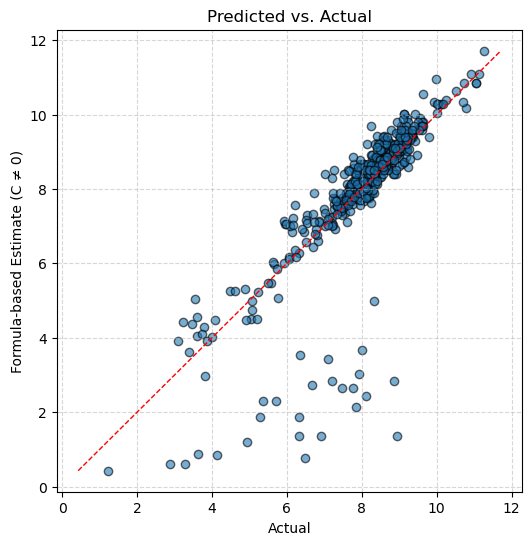

In [39]:
# predicted vs actual for just the test data
plot_predicted_vs_actual(y_test[mask], X_test.loc[mask, 'speed_est'], y_pred_label = 'Formula-based Estimate (C ≠ 0)')

#### Features with High Correlation

The features correlated most highly with speed were `cadence`, `gear_ratio`, `seated`, and `left_pco`. Let's fit a model using just those features. 

In [40]:
# Subset of predictors 
predictors = ["cadence", "gear_ratio", 'seated', 'left_pco']

# Fit model
model = LinearRegression()
model.fit(X_train[predictors], y_train)

# Predictions (must also use same predictors in X_test)
y_pred = model.predict(X_test[predictors])


Performance metrics indicate that this simple model is already better than our baseline model. Without any accomodations for zero:

- The $R^2$ *increases* appreciably from $0.393$ to $0.828$ 
- $RMSE$ *decreases* from $1.009$ to $0.646$ m/s.  

In [41]:
# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Coefficients:", dict(zip(predictors, model.coef_)))
print("Intercept:", model.intercept_)
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f} m/s")


Coefficients: {'cadence': 0.015739411214089085, 'gear_ratio': 3.0669310240218226, 'seated': 1.125348459134063, 'left_pco': 0.025125404403632964}
Intercept: -2.5879155313470497
R²: 0.828
RMSE: 0.646 m/s


The scatter plot shows that model's predictions are much closer to actuals. The linear model is most ofen wrong, however, at lower speeds. 

<Axes: title={'center': 'Predicted vs. Actual'}, xlabel='Actual', ylabel='Predicted'>

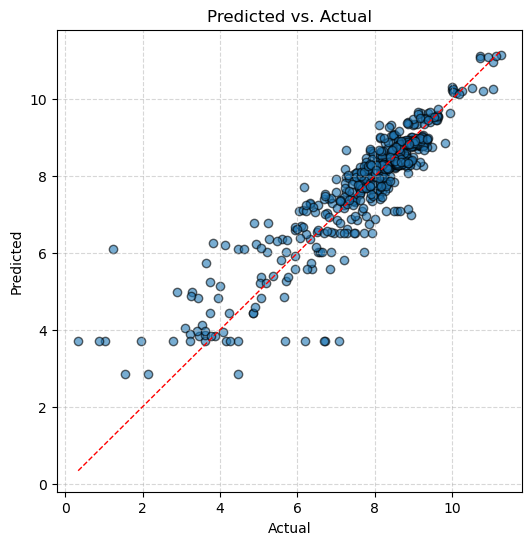

In [42]:
plot_predicted_vs_actual(y_test, y_pred)

---
### Feature Selection

To see if we can further improve the model, we'll use forward feature selection (with cross validation). 

By iteratively adding the next best feature to the model, we should be able to identify a set of better-performing features. 

In [43]:
from sklearn.feature_selection import SequentialFeatureSelector

X_candidates = X_train.drop(columns = ['speed_est'])

multi_model = LinearRegression()
sfs = SequentialFeatureSelector(multi_model, n_features_to_select="auto", direction="forward", cv=5)
sfs.fit(X_candidates, y_train)

selected_features = X_candidates.columns[sfs.get_support()].tolist()

print("Selected features:", selected_features)


Selected features: ['cadence', 'gear_ratio', 'altitude_change', 'seated']


In [44]:
# fit a model based on the selected features

multi_model.fit(X_train[selected_features], y_train)
y_pred = multi_model.predict(X_test[selected_features])

The `SequentialFeatureSelector()` replaced `left_pco` with `altitude_change`.   

As a consequence

- The $R^2$ *increases* slightly from $0.828$ to $0.831$ 
- $RMSE$ *decreases* slightly from $0.646$ to $0.641$ m/s.  


In [52]:
# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Coefficients:", dict(zip(selected_features, multi_model.coef_)))
print("Intercept:", multi_model.intercept_)
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f} m/s")


Coefficients: {'cadence': 0.019738078710131647, 'gear_ratio': 2.979108708192612, 'altitude_change': -0.9073596329680913, 'seated': 1.229545957542553}
Intercept: -2.5323123094327746
R²: 0.831
RMSE: 0.641 m/s


Given the modest improvement, it's not surprising the scatter plot looks remarkably similar. 

One notable benefit, though, is the model is more easily interpretable. More people understand what elevation change is and how it relates to speed than they do platform center offset. 

<Axes: title={'center': 'Predicted vs. Actual'}, xlabel='Actual', ylabel='Predicted'>

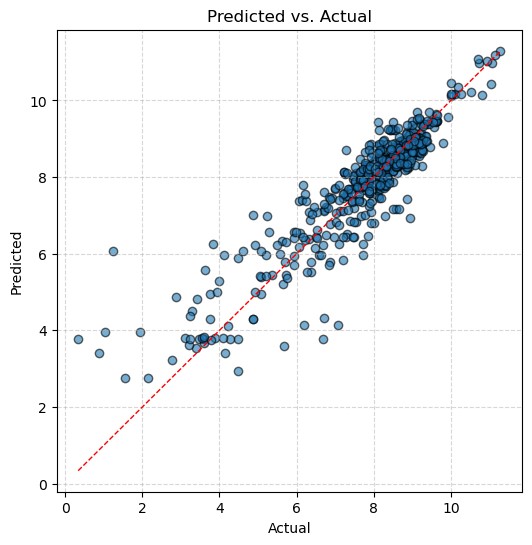

In [46]:
plot_predicted_vs_actual(y_test, y_pred)


Finally, we can refit a model using the same features and orindary least squares, which will make it possible to validate our results and guage feature importance. 

The model summary confirms that each of the selected features is statistically significant. The feature with the highest correlation to speed, `gear_ratio`, also has the largest coefficient. Although we didn't normalize our feature values, the result is consistent with expectations. The feature with the next highest correlation, `seated`, has the next highest coefficient. 

Anectodally, it's perhaps surprising that `power` wasn't selected as a feature. Again, experience suggests that the harder that a rider pedals, the faster they go. However, we saw in our EDA that power and speed aren't directly correlated. A more accurate statement would be to say that the harder a rider pedals, the faster their cadence, but that's only true under the same set of circumstances (e.g., climbing a hill).   

In [47]:
import statsmodels.api as sm

X_ols = X_train[selected_features]
# Add a constant (intercept) to X
X_ols = sm.add_constant(X_ols)

ols_model = sm.OLS(y_train, X_ols).fit()

# Get summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         enhanced_speed   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     3397.
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:46:07   Log-Likelihood:                -2283.3
No. Observations:                2496   AIC:                             4577.
Df Residuals:                    2491   BIC:                             4606.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.5323      0.112    -

-------


### Results and Analysis

This analysis demonstrates that telemetry-based modeling can predict cycling speed with a high degree of accuracy.

The formula-based model (based on the mechanical relationship between gear ratio, cadence, wheel size, and speed) does a reasonable job of predicting speed, but only when $cadence ≠ 0$. When $cadence = 0$, the model is incapable of predicting non-zero speeds. When $cadence ≠ 0$:

- $R^2$ = $0.393$ 
- $RMSE$ = $1.009$ m/s 


Using simple linear regression, we dramatically improve model performance. Not only does the resulting ML-based model work in a wider range of scenarios (i.e., $cadence = 0$), it produces better results in *all* scenarios:  

- $R^2$ = $0.831$
- $RMSE$ = $0.641$ m/s

Future work could extend this analysis by:

- Exploring nonlinear models (e.g., random forests, gradient boosting).
- Testing generalization across multiple riders and terrains.

Already, though, these models shown here give us a better understanding of cycling's avialable telemetry and the insights these data offer into cycling performance.

In [48]:
speed_df = df[['minutes', 'enhanced_speed', 'speed_est']]
speed_df['speed_lm'] = multi_model.predict(df.loc[:, selected_features])

C:\Users\sieli\AppData\Local\Temp\ipykernel_43384\1554088073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_df['speed_lm'] = multi_model.predict(df.loc[:, selected_features])


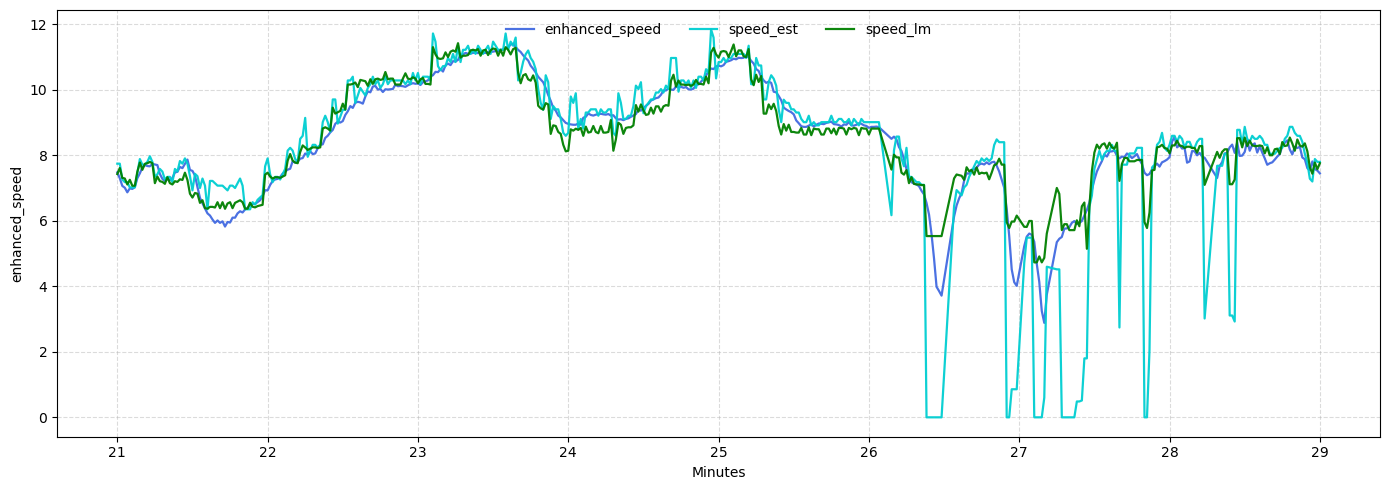

In [56]:
plot_trends_multi_axis(
    speed_df[speed_df["minutes"].between(21, 29, inclusive="both")], 
    #speed_df[speed_df["minutes"].between(11, 19, inclusive="both")],  
    ['enhanced_speed', 'speed_est', 'speed_lm' ], 
    colors = ['royalblue', 'darkturquoise', 'green'],
    x_col = 'minutes', 
    axis_for = {'enhanced_speed': 0, 'speed_est': 0, 'speed_lm' :0}
)